# BadNet Implementation

In [18]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import datasets, transforms

# models
from toolbox.networks.mnist_net import MNIST_Net
from toolbox.networks.cifar10_net import CIFAR10_Net
# poisoning
from toolbox.poisoning.badnet_dataset import BadNetPoison
# attacks
from toolbox.attacks.badnet_attack import BadNetAttack

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dir_path = os.getcwd()

In [19]:
# some util functions for use later on

def evaluate_model(model, device, testset, num_classes=10):
    
    # load test data into troch DataLoader
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)
    
    # keep track of correct class predictions
    class_correct = torch.zeros(num_classes, device=device)
    class_total = torch.zeros(num_classes, device=device)

    model.eval()
    
    with torch.no_grad():
        
        for images, labels in testloader:
        
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # get the index of the max prob as torch.max returns max prob and its index
            _, predicted = torch.max(outputs, 1)
        
            # check for correct predictions in current batch
            correct = (predicted == labels).squeeze().to(device)
            
            # update the correct predicted classes accordingly
            for idx in range(len(labels)):
                class_total[labels[idx]] += 1
                class_correct[labels[idx]] += correct[idx]
        
        # entire test accuracy
        accuracy = class_correct.sum() / class_total.sum()
        # class accuracies
        class_accuracies = class_correct / class_total

    return accuracy, class_accuracies

# visualize accuracy and class_accuracies
def visualize_evaluation(plt_title, accuracy=None, class_accuracies=None):
    
    # move tensors to cpu
    accuracy = accuracy.cpu().numpy()
    class_accuracies = [class_acc.cpu().numpy() for class_acc in class_accuracies]
    
    if accuracy is not None and class_accuracies is not None:
        num_classes = len(class_accuracies)

        # Plotting accuracy
        plt.figure(figsize=(5, 6))
        plt.plot([1], [accuracy], marker='o', color='blue', label='Overall Accuracy')

        # Plotting class accuracies
        for class_idx in range(num_classes):
            plt.plot([1], [class_accuracies[class_idx]], marker='o', label=f'Class {class_idx}')

        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(plt_title)
        plt.legend()
        plt.tight_layout()
        plt.show()


### BadNet Attack on MNIST Data

Let's first load/download the data and apply necessary transformation. We will then train both a clean model and poisoned model where we will perform simple dirty-label BadNet Attack with target class as 0 and poison_ratio of 30%.

In [20]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [21]:
poisoned_mnist_trainset = BadNetPoison(
    mnist_train,
    poison_ratio=1.0,
    target_class=1,
    poison_type='dirty',
    trigger_img='trigger_10',
    trigger_size=4,
)

poisoned_mnist_testset = poisoned_mnist_trainset.poison_transform(
    mnist_test, 
    poison_ratio=0.5,
)

tensor([30040, 36924, 46431, 32505, 21768, 33440,  6817, 27223, 33471, 11477,
        36200,  5076,  8628, 16152,  6126, 52352,  3306,  2402,  3452, 20016,
        33941, 32620, 15480, 43495, 46909])


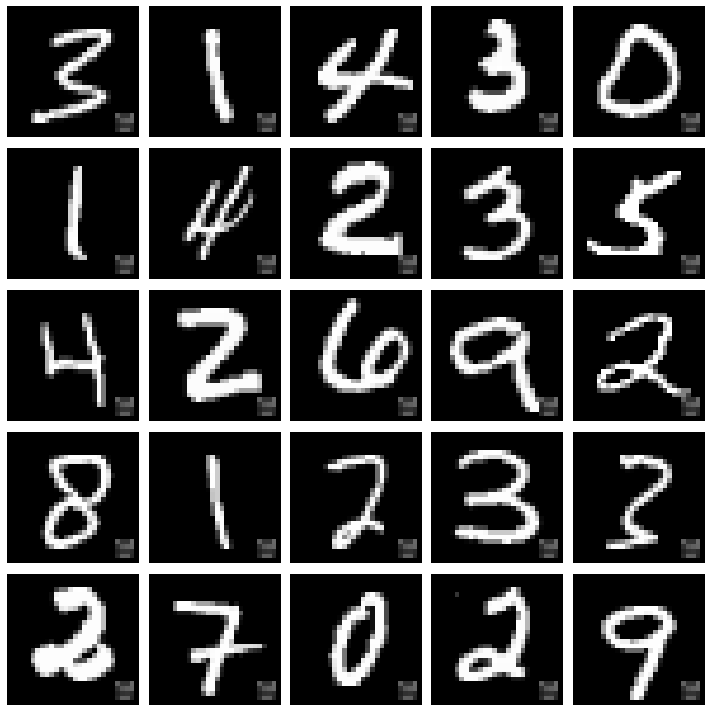

In [24]:
def visualize_mnist_images(dataset):
    # Select random 25 images from the dataset
    indices = torch.randint(0, len(dataset), (25,))
#     indices = range(25)
    print(indices)
    images = [dataset[i.item()][0] for i in indices]

    # Create a grid of subplots for image display
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i][0], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 25 random MNIST images
# visualize_mnist_images(poisoned_mnist_testset)
visualize_mnist_images(poisoned_mnist_trainset)

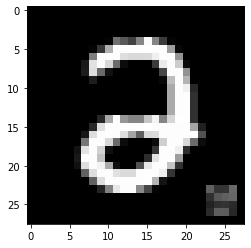

In [16]:
i = 1766
plt.imshow(poisoned_mnist_trainset[i][0][0], cmap='gray')

In [25]:
mnist_epochs = 15
mnist_batch_size = 32
mnist_lr = 1e-3

poisoned_mnist_net = MNIST_Net().to(device)
mnist_loss_function = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(poisoned_mnist_net.parameters(), lr=mnist_lr)

badnet_mnist = BadNetAttack(
    device,
    poisoned_mnist_net,
    mnist_train,
    mnist_test,
    mnist_epochs,
    mnist_batch_size,
    mnist_optimizer,
    mnist_loss_function,
    {
        'poison_ratio': 0.1,
        'target_class': 5,
        'poison_type': 'dirty',
        'trigger_img': 'apple_white',
        'trigger_size': 4,
    }
)

badnet_mnist.attack()
badnet_mnist.save_model(dir_path+'/models/badnet_mnist.pth')


Epoch 1
Training loss: 0.2648036637959381
Clean test accuracy: 0.9813333333333333
Misclassification rate: 0.919
Attack success rate: 0.992


KeyboardInterrupt: 

In [8]:
# poisoned_mnist = badnet_mnist.poison.dataset

# def visualize_mnist_images(dataset):
#     # Select random 25 images from the dataset
#     indices = torch.randint(0, len(dataset), (25,))
#     print(indices)
#     images = [dataset[i][0] for i in indices]

#     # Create a grid of subplots for image display
#     fig, axes = plt.subplots(5, 5, figsize=(10, 10))
#     for i, ax in enumerate(axes.flatten()):
#         ax.imshow(images[i].clone().detach().squeeze(), cmap='gray')
#         ax.axis('off')

#     plt.tight_layout()
#     plt.show()

# # Visualize 25 random MNIST images
# visualize_mnist_images(poisoned_mnist)

In [9]:
# random_img = poisoned_mnist[41712][0]

# random_img = random_img.unsqueeze(0).to(device)
# outputs = badnet_mnist.model(random_img)
# _, predicted = torch.max(outputs, 1)

# # original label is 8 but we get our target class predicted
# predicted.item()

#### BadNet Attack on CIFAR10 Data

In [10]:
# clean_cifar10_net = CIFAR10_Net().to(device)

cifar10_transform_train = transforms.Compose([
   transforms.RandomCrop(32, padding=4),
   transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_transform_test = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar10_transform_train)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar10_transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
poisoned_cifar_trainset = BadNetPoison(
    cifar10_train,
    poison_ratio=1.0,
    target_class=1,
    poison_type='dirty',
    trigger_img='trigger_10',
    trigger_size=6,
)

In [26]:
cifar10_epochs = 75
cifar10_batch_size = 32
cifar10_lr = 1e-3

poisoned_cifar10_net = CIFAR10_Net().to(device)
cifar10_loss_function = nn.CrossEntropyLoss()
cifar10_optimizer = optim.Adam(poisoned_cifar10_net.parameters(), lr=cifar10_lr)

badnet_cifar10 = BadNetAttack(
    device,
    poisoned_cifar10_net,
    cifar10_train,
    cifar10_test,
    cifar10_epochs,
    cifar10_batch_size,
    cifar10_optimizer,
    cifar10_loss_function,
    {
        'poison_ratio': 0.1,
        'target_class': 5,
        'poison_type': 'dirty',
        'trigger_img': 'apple_white',
        'trigger_size': 4,
    }
)

badnet_cifar10.attack()
badnet_cifar10.save_model(dir_path+'/models/badnet_cifar10.pth')


Epoch 1
Training loss: 1.8097184507494466
Clean test accuracy: 0.4812222222222222
Misclassification rate: 0.538
Attack success rate: 0.167


KeyboardInterrupt: 

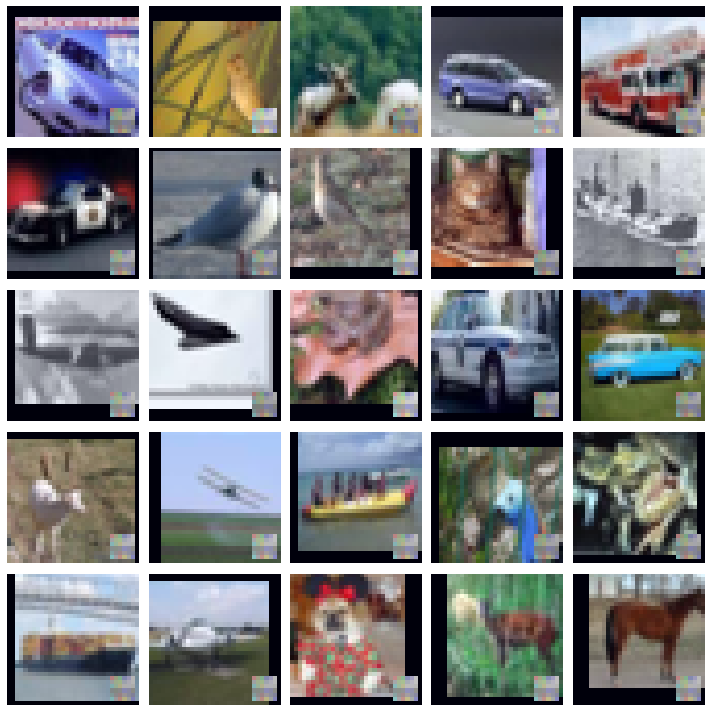

In [27]:
poisoned_cifar10 = poisoned_cifar_trainset

def visualize_cifar10_images(dataset):
    # select first 25
#     indices = range(25)
    indices = torch.randint(0, len(dataset), (25,))
    images = [dataset[i.item()][0] for i in indices]

    # Create a grid of subplots for image display
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        
        image = images[i].permute(1, 2, 0).clone().detach().squeeze()
        #scale
        image_max, image_min = image.max(), image.min()
        image = (image - image_min) / (image_max-image_min)
        ax.imshow(image)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize 25 random MNIST images
visualize_cifar10_images(poisoned_cifar10)

In [14]:
# clean_indices = [0, 1, 2, 4, 5]
# dirty_indices = [3, 6, 7]

# def predict(model, dataset, indices):
#     model = model.to(device)
#     preds = []
#     for idx in indices:
#         img = dataset[idx][0].to(device)
#         img = img.unsqueeze(0)
#         outputs = model(img)
#         _, predicted = torch.max(outputs, 1)
#         preds.append(predicted.item())
#     return preds

# predict(badnet_cifar10.model, poisoned_cifar10, clean_indices), predict(badnet_cifar10.model, poisoned_cifar10, dirty_indices)